In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
import yfinance as yf
import xgboost as xgb
import matplotlib.pyplot as plt

In [2]:
import XGBoost 
from XGBoost import SalesPredictionModel

In [10]:
f = yf.Ticker.get_info

In [58]:
msft = yf.Ticker("bbva.mc")
print(msft)

yfinance.Ticker object <BBVA.MC>


In [59]:
data = msft.history(period="max")

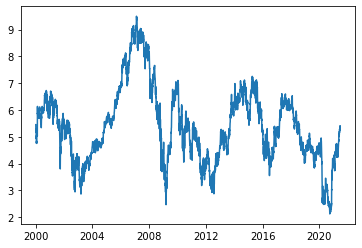

In [60]:
plt.plot(data['Open'])

In [61]:
data = data.drop(columns=["Volume","Stock Splits","Dividends"])

In [62]:
data.head()

,Open,High,Low,Close
Date,,,,
2000-01-03,5.451844,5.478625,5.413585,5.425062
2000-01-04,5.356193,5.390626,5.264373,5.283502
2000-01-05,5.233766,5.260547,5.141946,5.164901
2000-01-06,5.164901,5.164901,5.164901,5.164901
2000-01-07,5.275852,5.275852,5.176380,5.229942


In [63]:
data = data.drop(columns=["High","Low"])

In [64]:
def train_test_split(data, n_test):
    """
    Function to split dataset into train and test
        - data
        - n_test: desired number of rows in test dataset
    """
    return data[:-n_test].reset_index(drop=True), data[-n_test:].reset_index(drop=True)

In [65]:
def series_to_supervised(data,n_inputs=10,n_outputs=1):
    """
    Function to transform time-series data to supervised training data
        - data
        - n_inputs: Number of days to look back
        - n_outputs: Number of days to look after
        - dropnan
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    new_data = pd.DataFrame(data)
    columns, names = list(), list()
    # With this loop we extract the input values, i.e. the values of the variables
    # for the previous n_inputs time steps
    for i in range(n_inputs, 0, -1):
        columns.append(new_data.shift(i))
        names += [('%s(t-%d)' % (data.columns[j], i)) for j in range(n_vars)]
    # With this loop we extract the actual values of the variables for the actual
    # time step and, if desired, we will add the next n_outputs time steps as columns
    for i in range(0, n_outputs):
        columns.append(new_data.shift(-i))  
        if i == 0:
            names += [('%s(t)' % (data.columns[j])) for j in range(n_vars)]
        else:
            names += [('%s(t+%d)' % (data.columns[j], i)) for j in range(n_vars)]
    data_result = pd.concat(columns, axis=1)
    data_result.columns = names
    data_result.dropna(inplace=True)
    data_result = data_result.infer_objects()
    return data_result

In [96]:
data_final=series_to_supervised(data)
train,test=train_test_split(data_final,20)

In [97]:
train

,Open(t-10),Close(t-10),Open(t-9),Close(t-9),Open(t-8),Close(t-8),Open(t-7),Close(t-7),Open(t-6),Close(t-6),...,Open(t-4),Close(t-4),Open(t-3),Close(t-3),Open(t-2),Close(t-2),Open(t-1),Close(t-1),Open(t),Close(t)
0,5.451844,5.425062,5.356193,5.283502,5.233766,5.164901,5.164901,5.164901,5.275852,5.229942,...,5.126643,5.042474,5.076149,5.026005,5.014434,4.902574,4.937288,4.999005,5.033719,4.952716
1,5.356193,5.283502,5.233766,5.164901,5.164901,5.164901,5.275852,5.229942,5.287329,5.145772,...,5.076149,5.026005,5.014434,4.902574,4.937288,4.999005,5.033719,4.952716,4.941145,4.848571
2,5.233766,5.164901,5.164901,5.164901,5.275852,5.229942,5.287329,5.145772,5.126643,5.042474,...,5.014434,4.902574,4.937288,4.999005,5.033719,4.952716,4.941145,4.848571,4.759854,4.840857
3,5.164901,5.164901,5.275852,5.229942,5.287329,5.145772,5.126643,5.042474,5.076149,5.026005,...,4.937288,4.999005,5.033719,4.952716,4.941145,4.848571,4.759854,4.840857,4.860145,4.833144
4,5.275852,5.229942,5.287329,5.145772,5.126643,5.042474,5.076149,5.026005,5.014434,4.902574,...,5.033719,4.952716,4.941145,4.848571,4.759854,4.840857,4.860145,4.833144,4.794570,4.732854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5418,4.652500,4.676000,4.700000,4.665000,4.735500,4.772500,4.770000,4.806500,4.820000,4.821500,...,4.875500,4.909000,4.890000,4.903000,4.835000,4.892000,4.930000,5.028000,5.000000,5.008000
5419,4.700000,4.665000,4.735500,4.772500,4.770000,4.806500,4.820000,4.821500,4.869500,4.928000,...,4.890000,4.903000,4.835000,4.892000,4.930000,5.028000,5.000000,5.008000,5.050000,5.125000
5420,4.735500,4.772500,4.770000,4.806500,4.820000,4.821500,4.869500,4.928000,4.875500,4.909000,...,4.835000,4.892000,4.930000,5.028000,5.000000,5.008000,5.050000,5.125000,5.050000,4.995500
5421,4.770000,4.806500,4.820000,4.821500,4.869500,4.928000,4.875500,4.909000,4.890000,4.903000,...,4.930000,5.028000,5.000000,5.008000,5.050000,5.125000,5.050000,4.995500,5.011000,5.003000


In [98]:
train_X, train_y = train.drop('Close(t)', axis=1), train.drop(test.columns.difference(['Close(t)']), axis=1)
test_X, test_y = test.drop('Close(t)', axis=1), test.drop(test.columns.difference(['Close(t)']), axis=1)

In [ ]:
def fit(n_test, history=None):
    if history is None:
        train, test = train_test_split(n_test)
        train_X, train_y = train.drop('Close(t)', axis=1), train.drop(train.columns.difference(['Close(t)']), axis=1)
        model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000)
        model.fit(train_X, train_y)
        return
    else:
        train_X, train_y = history.drop('Close(t)', axis=1), history.drop(history.columns.difference(['Close(t)']), axis=1)
        validation_model = xgb.XGBRegressor(objective='reg:squarederror',
                                            n_estimators=700,
                                            colsample_bytree=1,
                                            max_depth=3,
                                            reg_alpha=0,
                                            reg_lambda=1,
                                            subsample=0.9)
        validation_model.fit(train_X, train_y)
        return validation_model

In [ ]:

def validate(self, n_test):
    """
    Function that evaluates all the predictions obtained with our model with a walk forward validation method
        - data
        - n_test: desired number of predictions
    """
    predictions = list()
    expected = list()
    train, test = train_test_split(n_test)
    test_X, test_y = test.drop('Close(t)', axis=1), test.drop(test.columns.difference(['Close(t)']), axis=1)
    history = train.copy(deep=True)
    for i in range(n_test):
        test_X_iter, test_y_iter = test_X.iloc[i:i+1, :], test_y.iloc[i:i+1, :]
        test_model = fit(n_test, history=history)
        y_prediction = test_model.predict(test_X_iter)
        new_row = [test_X_iter.iloc[0, j] for j in range(len(test_X_iter.columns))]
        new_row.append(y_prediction[0])
        history.loc[len(history)] = new_row
        print("Prediction: %.1f | Expected: %.1f | GAP: %.1f" % (y_prediction[0], test_y_iter.iloc[0, 0], test_y_iter.iloc[0, 0] - y_prediction[0]))
        predictions.append(y_prediction[0])
        expected.append(test_y_iter.iloc[0, 0])
    mae = mean_absolute_error(expected, predictions)
    rmse = np.sqrt(mean_squared_error(expected, predictions))
    return expected, predictions, mae, rmse


In [ ]:
def predict(self, test_X):
        return self.__model.predict(test_X)

In [99]:
model_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000,max_depth=4,reg_alpha=0.01)


In [100]:
model_xgb.fit(train_X, train_y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=4,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0.01, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [101]:
test_X

,Open(t-10),Close(t-10),Open(t-9),Close(t-9),Open(t-8),Close(t-8),Open(t-7),Close(t-7),Open(t-6),Close(t-6),...,Close(t-5),Open(t-4),Close(t-4),Open(t-3),Close(t-3),Open(t-2),Close(t-2),Open(t-1),Close(t-1),Open(t)
0,4.8695,4.9280,4.8755,4.9090,4.890,4.9030,4.835,4.8920,4.930,5.0280,...,5.0080,5.050,5.1250,5.050,4.9955,5.011,5.003,5.010,5.121,5.126
1,4.8755,4.9090,4.8900,4.9030,4.835,4.8920,4.930,5.0280,5.000,5.0080,...,5.1250,5.050,4.9955,5.011,5.0030,5.010,5.121,5.126,5.100,5.100
2,4.8900,4.9030,4.8350,4.8920,4.930,5.0280,5.000,5.0080,5.050,5.1250,...,4.9955,5.011,5.0030,5.010,5.1210,5.126,5.100,5.100,5.110,5.095
3,4.8350,4.8920,4.9300,5.0280,5.000,5.0080,5.050,5.1250,5.050,4.9955,...,5.0030,5.010,5.1210,5.126,5.1000,5.100,5.110,5.095,5.084,5.080
4,4.9300,5.0280,5.0000,5.0080,5.050,5.1250,5.050,4.9955,5.011,5.0030,...,5.1210,5.126,5.1000,5.100,5.1100,5.095,5.084,5.080,5.143,5.200
5,5.0000,5.0080,5.0500,5.1250,5.050,4.9955,5.011,5.0030,5.010,5.1210,...,5.1000,5.100,5.1100,5.095,5.0840,5.080,5.143,5.200,5.126,5.151
6,5.0500,5.1250,5.0500,4.9955,5.011,5.0030,5.010,5.1210,5.126,5.1000,...,5.1100,5.095,5.0840,5.080,5.1430,5.200,5.126,5.151,5.136,5.153
7,5.0500,4.9955,5.0110,5.0030,5.010,5.1210,5.126,5.1000,5.100,5.1100,...,5.0840,5.080,5.1430,5.200,5.1260,5.151,5.136,5.153,5.226,5.217
8,5.0110,5.0030,5.0100,5.1210,5.126,5.1000,5.100,5.1100,5.095,5.0840,...,5.1430,5.200,5.1260,5.151,5.1360,5.153,5.226,5.217,5.249,5.228
9,5.0100,5.1210,5.1260,5.1000,5.100,5.1100,5.095,5.0840,5.080,5.1430,...,5.1260,5.151,5.1360,5.153,5.2260,5.217,5.249,5.228,5.286,5.290


In [102]:
a = model_xgb.predict(test_X)

In [103]:
a

array([5.1302695, 5.084005 , 5.052085 , 5.1016316, 5.2222285, 5.1716833,
       5.171951 , 5.196689 , 5.24241  , 5.290593 , 5.203427 , 5.3144855,
       5.2998166, 5.213448 , 5.2245007, 5.2351584, 5.330301 , 5.4282575,
       5.352566 , 5.275741 ], dtype=float32)

In [104]:
test_y

,Close(t)
0,5.100
1,5.110
2,5.084
3,5.143
4,5.126
5,5.136
6,5.226
7,5.249
8,5.286
9,5.217


In [105]:
mae = mean_absolute_error(test_y, a)
print(mae)

0.054595112800598145


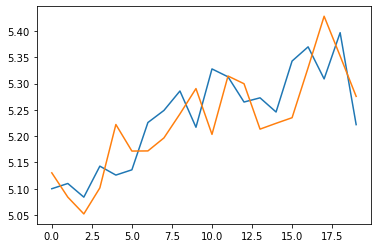

In [106]:
plt.plot(test_y.index,test_y)
plt.plot(a)